<a href="https://colab.research.google.com/github/Hradini/ML_Project/blob/main/SegmentationCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/ML Datasets/images.zip'

In [ ]:
!unzip '/content/gdrive/MyDrive/ML Datasets/covertedLabels.zip'

In [5]:
import os

input_dir = "/content/images"
target_dir = "/content/content/covertedLabels"
img_size = (512, 512)
num_classes = 3

batch_size = 16

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 1000
/content/images/0.png | /content/content/covertedLabels/label_0.png
/content/images/1.png | /content/content/covertedLabels/label_1.png
/content/images/10.png | /content/content/covertedLabels/label_10.png
/content/images/100.png | /content/content/covertedLabels/label_100.png
/content/images/101.png | /content/content/covertedLabels/label_101.png
/content/images/102.png | /content/content/covertedLabels/label_102.png
/content/images/103.png | /content/content/covertedLabels/label_103.png
/content/images/104.png | /content/content/covertedLabels/label_104.png
/content/images/105.png | /content/content/covertedLabels/label_105.png
/content/images/106.png | /content/content/covertedLabels/label_106.png


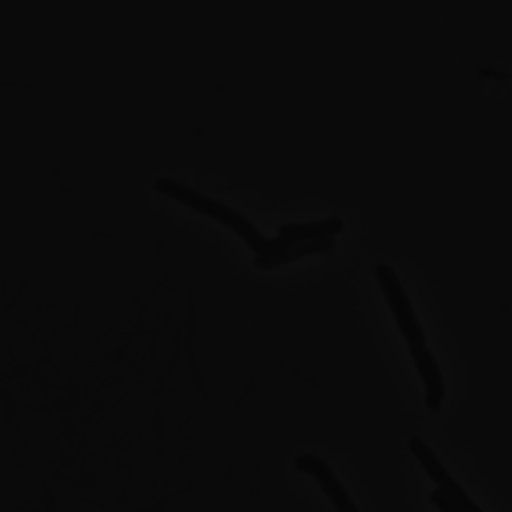

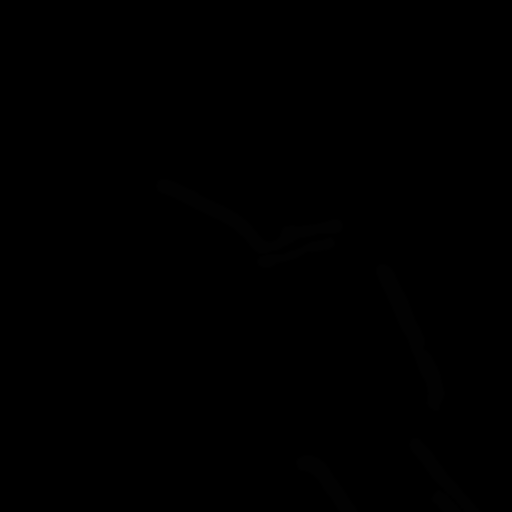

In [6]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[10]))


display(Image(filename=target_img_paths[10]))

In [7]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class EcoliCells(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size] #paths to images in one batch
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size] #paths to masks in one batch
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32") #creating an array of zeros 
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size) #loading image as a PIL instance
            x[j] = img #each image is one array element 
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2) #expanding dimension of mask?
        return x, y

In [8]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [9]:
import random

# Split our img paths into a training and a validation set
val_samples = 200
random.Random(13).shuffle(input_img_paths)
random.Random(13).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = EcoliCells(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = EcoliCells(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [10]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("Ecoli.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
50/50 [==============================] - 2015s 40s/step - loss: 0.7811 - val_loss: 0.5813
Epoch 2/15
50/50 [==============================] - 2006s 40s/step - loss: 0.2906 - val_loss: 2.2134
Epoch 3/15
50/50 [==============================] - 2008s 40s/step - loss: 0.2584 - val_loss: 0.2653
Epoch 4/15
50/50 [==============================] - 2010s 40s/step - loss: 0.2426 - val_loss: 0.1961
Epoch 5/15
50/50 [==============================] - 2010s 40s/step - loss: 0.2322 - val_loss: 0.2239
Epoch 6/15
50/50 [==============================] - 2012s 40s/step - loss: 0.1560 - val_loss: 1.8763
Epoch 7/15
50/50 [==============================] - 2012s 40s/step - loss: 0.1397 - val_loss: 1.3478
Epoch 8/15
50/50 [==============================] - 2011s 40s/step - loss: 0.1338 - val_loss: 2.4472
Epoch 9/15
50/50 [==============================] - 2011s 40s/step - loss: 0.1318 - val_loss: 7.7100
Epoch 10/15
50/50 [==============================] - 2012s 40s/step - loss: 0.1300 - val_lo

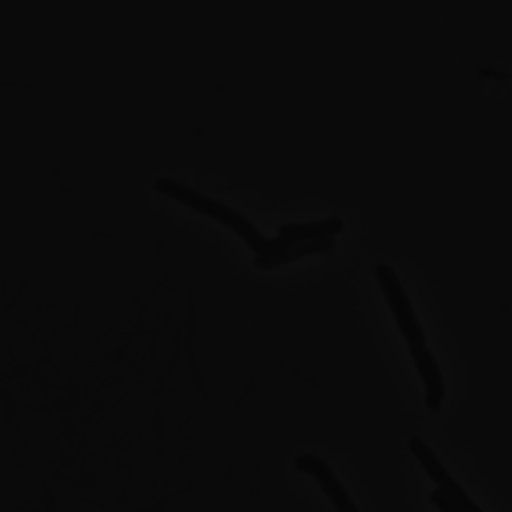

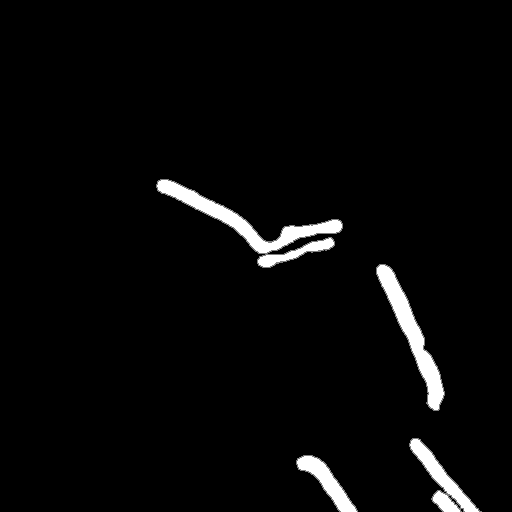

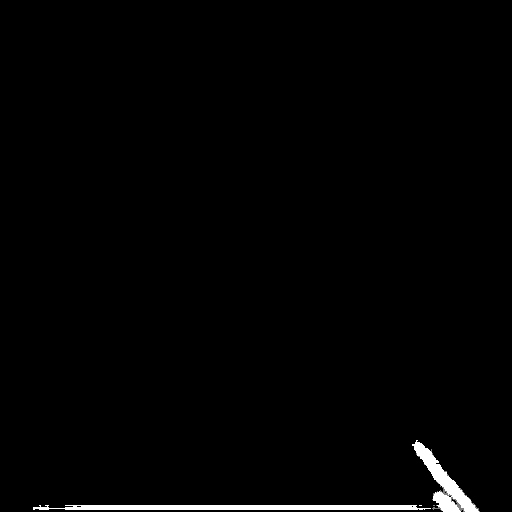

In [11]:
# Generate predictions for all images in the validation set

val_gen = EcoliCells(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.